In [14]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

from utils.cross_validation import cross_validate
from utils.metrics import aucroc
from utils.estimators import DecisionTreeWrapper
from utils.base_set import X_train, y_train, seed
from sklearn.ensemble import RandomForestClassifier


### Forest

In [18]:
mean_val_scores = []
std_val_scores = []
mean_train_scores = []
std_train_scores = []

k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
cols_val = [f"split_val_{i}" for i in range(k)]
cols_train = [f"split_train_{i}" for i in range(k)]
max_features_values = [1, 2, 5, 10, 'auto', 'sqrt', 'log2']
for mf in max_features_values:
    rf = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=mf)
    auc_scores, _ = cross_validate(rf, X_train, y_train, metric=aucroc, use_decision=True, cv=cv)
    mean_val_scores.append(auc_scores.mean_val.aucroc)
    std_val_scores.append(auc_scores[cols_val].std(axis=1).aucroc)
    mean_train_scores.append(auc_scores.mean_train.aucroc)
    std_train_scores.append(auc_scores[cols_train].std(axis=1).aucroc)

AttributeError: 'RandomForestClassifier' object has no attribute 'clone'

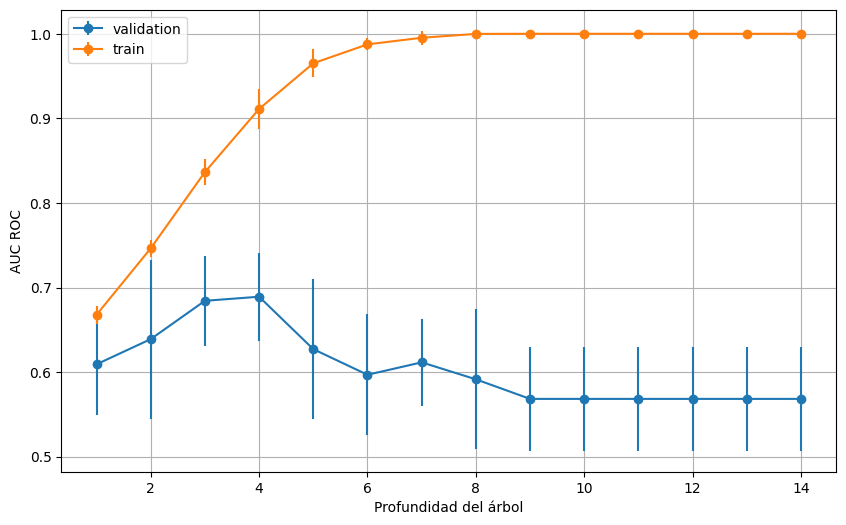

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Entrenamiento', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Validación', color='orange')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color='orange')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('AUC ROC')
plt.title('Curva de Aprendizaje para RandomForest (n_estimators=200)')
plt.legend()
plt.grid(True)
plt.show()